# Apply Logistic Regression on Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\HIMANSHU NEGI\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:51<00:00, 1690.05it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [5] Assignment 5: Apply Logistic Regression

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc


from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

# Applying Logistic Regression

In [25]:
#spilliting data 
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_1, X_test, y_1, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [26]:
#code for VECTORIZER
count_vect = CountVectorizer(min_df = 10) 
Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 8139)
the number of unique words : 8139


In [27]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [47]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l1',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.5, 0.8425503846776905, 0.9576780915012392, 0.9941944405528373, 0.9994771944594137, 0.9997959150727305, 0.9997610584396648, 0.9997736336803226, 0.9998875141326604]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.5, 0.8391712041255219, 0.935746474098139, 0.9160812123926568, 0.8690068918605829, 0.85190463559747, 0.8460940422632803, 0.8474929477660343, 0.8395385893208752]


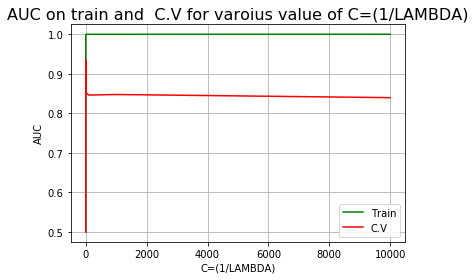

In [54]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA)',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [28]:
# L.R with optimal c
lr = LogisticRegression(penalty='l1',C=.01)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha = %f is %f%%' % (0.01, acc))


The accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha = 0.010000 is 90.661552%


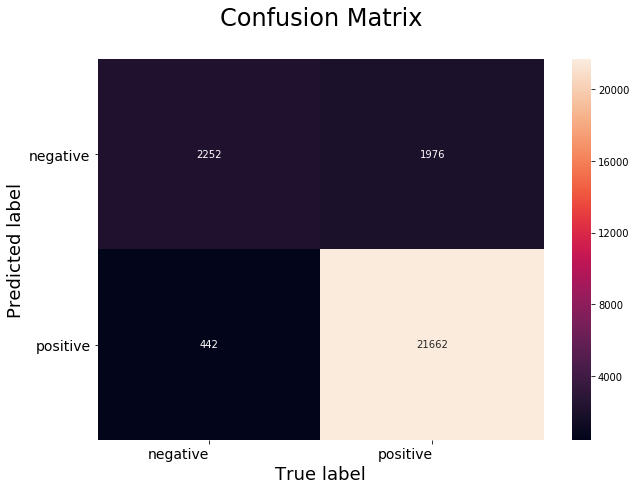

In [38]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [30]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



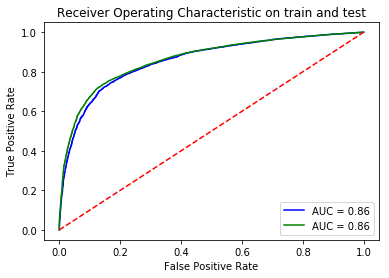

In [31]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
# SPARCITY OF our model 0.01

w = lr.coef_
print(np.count_nonzero(w))

1249


In [69]:
# SPARCITY OF our model 0.1

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(Xbow_tr_std, y_tr);
w = clf.coef_
print(np.count_nonzero(w))


5311


In [70]:
# SPARCITY OF our model 1

clf = LogisticRegression(C=1, penalty='l1');
clf.fit(Xbow_tr_std, y_tr);
w = clf.coef_
print(np.count_nonzero(w))

6810


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [30]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l2',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.9631493840317044, 0.9892487502173155, 0.9962185313635145, 0.998839586828789, 0.9991716107600338, 0.9993761853031468, 0.999317454495642, 0.9992613338579628, 0.9993557965793346]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9161191183582622, 0.9254361831051082, 0.9026155723331986, 0.8726337265511651, 0.8655700110460327, 0.8601471961261699, 0.8619146376722482, 0.8634052851755962, 0.8608954525493746]


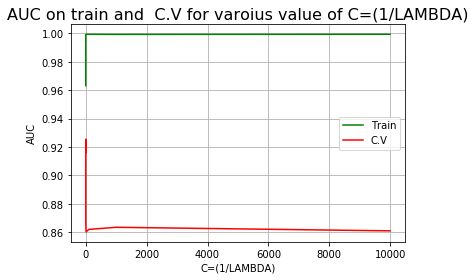

In [31]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA)',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()



In [32]:
# L.R with optimal c
lr = LogisticRegression(penalty='l2',C=0.001)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha = %f is %f%%' % (0.001, acc))


The accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha = 0.001000 is 91.329941%


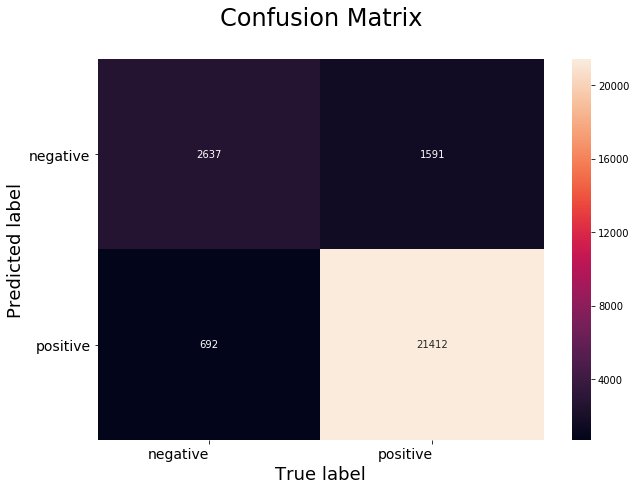

In [33]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [34]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



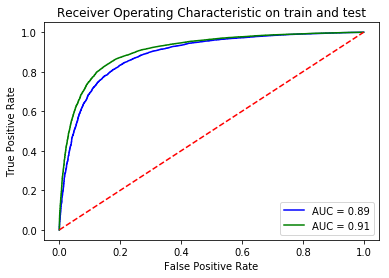

In [35]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [177]:
print("Vector before the addition of epsilon")
W_before_epsilon = lr.coef_
print(W_before_epsilon
     )

Vector before the addition of epsilon
[[-0.01720176 -0.00660118 -0.00317081 ... -0.0007471   0.01312499
   0.00814959]]


In [36]:
# Performing pertubation test (multicollinearity check) on BOW  
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)#loc=mean and scale is Std Dev
print("random value of epsilon")
print(epsilon)



print("Number of non zero elements in Xtrain sparse matrix")
no_of_non_zero = Xbow_tr_std.count_nonzero()

print(no_of_non_zero)


random value of epsilon
-3.4335880090706586e-05
Number of non zero elements in Xtrain sparse matrix
1363842


In [48]:
# Creating new sparse matrix with epsilon at same position 
#    of non-zero elements of X_train_vec_standard

from scipy.sparse import csr_matrix


indices_Xbow_tr = Xbow_tr_std.indices#index array of matrix
indptr_Xbow_tr = Xbow_tr_std.indptr#index pointer array of matrix

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = Xbow_tr_std.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_Xbow_tr,indptr_Xbow_tr),shape=Shape,dtype=float)
'''   
    csr_matrix((data, indices, indptr), [shape=(M, N)])

is the standard CSR representation where the column indices for row i are stored 
in indices[indptr[i]:indptr[i+1]] and their corresponding values are stored 
in data[indptr[i]:indptr[i+1]]. 

'''

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_tr = Xbow_tr_std + sparse_epsilon

print(Xbow_tr_std.shape)
print(epsilon_tr.shape)

(43008, 8123)
(43008, 8123)


In [49]:
# fitting the model
elr = LogisticRegression(penalty='l2',C=0.001)


elr.fit(epsilon_tr, y_tr)



LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [193]:
Wp_after_epsilon=elr.coef_

In [75]:
# Vector after the addition of epsilon
Wp_after_epsilon = elr.coef_+(10**-6)
Wp_before_epsilon= W_before_epsilon++(10**-6)
# Change in percentage vectors after adding epsilon
Per_change_vector =(((Wp_after_epsilon - Wp_before_epsilon))/Wp_before_epsilon)*100

 #Sort this percentage change_vector array after making all the elements positive in ascending order to visualize the change
Per_sorted_change_vector = (np.sort(np.absolute(Per_change_vector))[:,::-1])

Per_sorted_change_vector[0,0:10]

array([1.27400147, 1.12176915, 0.9970868 , 0.80710631, 0.49441904,
       0.45823817, 0.39359011, 0.38672621, 0.3812035 , 0.34499534])

In [126]:
percv1=np.percentile(Per_change_vector,[10,20,30,40,50,60,70,80,90,100],axis=1)

In [127]:
percv1

array([[-2.22043388e-03],
       [-1.07643307e-03],
       [-6.28455971e-04],
       [-3.56322699e-04],
       [-1.39831710e-04],
       [ 5.60156198e-05],
       [ 3.01666989e-04],
       [ 7.02796700e-04],
       [ 1.83963994e-03],
       [ 1.12176915e+00]])

In [130]:
percv2=np.percentile(Per_change_vector,[90,91,92,93,94,95,96,97,98,99,100],axis=1)

In [131]:
percv2

array([[0.00183964],
       [0.00209655],
       [0.00235144],
       [0.00290105],
       [0.00349977],
       [0.00396543],
       [0.00477589],
       [0.00637157],
       [0.00967806],
       [0.01655241],
       [1.12176915]])

In [132]:
percv3=np.percentile(Per_change_vector,[98.1,98.1,98.3,98.4,98.5,98.6,98.7,98.8,98.9,90,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100],axis=1)

In [133]:
percv3

array([[0.01008433],
       [0.01008433],
       [0.01145125],
       [0.01201849],
       [0.01291995],
       [0.01378069],
       [0.01441204],
       [0.01476352],
       [0.01573722],
       [0.00183964],
       [0.01854444],
       [0.02196653],
       [0.02614253],
       [0.03083574],
       [0.04025344],
       [0.05326905],
       [0.06191565],
       [0.07178267],
       [0.15928484],
       [1.12176915]])

 There is sudden change from 99.4th percentile so we will consider it as our threshold and we have to disgard them.

In [275]:
print("SO the vectors who have per_change-vector will be grater then below will be disgarded")
percvt=np.percentile(Per_change_vector,99.4,axis=1)
print(percvt)

SO the vectors who have per_change-vector will be grater then below will be disgarded
[0.03083574]


In [267]:
#finding the position index[0,i] having grater percentile then thershold
listt=[]
for i in range(0,8122):
    if(Per_change_vector[0,i]>0.03083574):
        listt.append(i)
   

### Following are the features whose % change is more then thershold with their weight values :

In [274]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,listt]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("following are the features whose % change is more then thershold with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

following are the features whose % change is more then thershold with their weight values :
  cappuccino	--> 	0.000232
     retired	--> 	-0.001562
       irish	--> 	0.001712
        jams	--> 	-0.001713
   organisms	--> 	0.001988
      afford	--> 	-0.002565
       pears	--> 	-0.003787
          ol	--> 	-0.004128
     compact	--> 	0.004903
      loaded	--> 	0.005123
     insulin	--> 	-0.006000
         flu	--> 	0.007854
     namaste	--> 	-0.008406
    believer	--> 	0.008814
        sooo	--> 	0.008923
        peel	--> 	-0.011433
       stone	--> 	0.012574
   walgreens	--> 	-0.012862
   stonewall	--> 	0.012894
    possibly	--> 	-0.013180
       decay	--> 	0.013281
      infant	--> 	-0.014454
   cupboards	--> 	0.014800
     closing	--> 	-0.014819
    wasteful	--> 	-0.015200
    response	--> 	-0.015574
   sweetners	--> 	0.015606
        rain	--> 	0.015904
   producers	--> 	-0.017439
       acids	--> 	0.018480
     italian	--> 	0.018608
        blog	--> 	-0.019548
      tended	--> 	0.020163
 

#### OBSERVATION :- After observing above percentile scores we can conclude that there is some significant change in the weights of the both vectors so we will disgard them by seeting the thershold and for rest we will use absolute value of weights(|w|) for important featuresb extraction.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [49]:
# 
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("Top 10 positive features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 features with their weight values :
       great	--> 	0.418346
         not	--> 	-0.286182
        best	--> 	0.283014
        good	--> 	0.264914
        love	--> 	0.255343
   delicious	--> 	0.250368
       loves	--> 	0.204715
     perfect	--> 	0.191873
   wonderful	--> 	0.188446
   excellent	--> 	0.177017


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [51]:

absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values :
 predominant	--> 	0.000011
         gel	--> 	-0.000011
      cookie	--> 	-0.000024
    parmesan	--> 	-0.000027
    handfuls	--> 	-0.000029
       outer	--> 	0.000030
subsequently	--> 	-0.000031
      appear	--> 	-0.000031
   memorable	--> 	-0.000032
        herb	--> 	0.000037


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [36]:
#code for VECTORIZER
count_vect  = TfidfVectorizer(ngram_range=(1,2), min_df=10)

Xbow_tr = count_vect.fit_transform(X_tr)
Xbow_test = count_vect.transform(X_test)
Xbow_cv = count_vect.transform(X_cv)
print("the type of count vectorizer :",type(X_tr))
print("the shape of out text BOW vectorizer : ",Xbow_tr.get_shape())
print("the number of unique words :", Xbow_tr.get_shape()[1])

the type of count vectorizer : <class 'list'>
the shape of out text BOW vectorizer :  (43008, 25574)
the number of unique words : 25574


In [37]:
# Data-preprocessing: Standardizing the data
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

In [86]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l1',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.5, 0.858566715958409, 0.9787848946200106, 0.99995249380891, 0.9999976112649991, 0.999997611264999, 0.999997611264999, 0.999997611264999, 0.999997611264999]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.5, 0.8541417319014037, 0.955485280966761, 0.9445213212025594, 0.9378023367462005, 0.934448795600838, 0.9243751286955627, 0.9136772013549904, 0.9132784190237084]


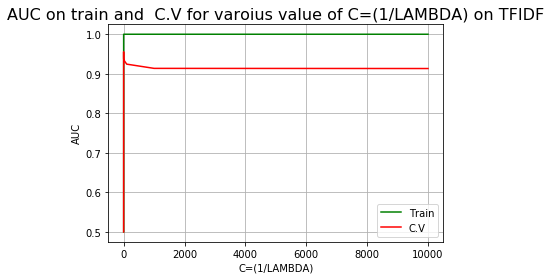

In [88]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) on TFIDF',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [38]:
# L.R with optimal c
lr = LogisticRegression(penalty='l1',C=.1)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha ON TFIDF = %f is %f%%' % (0.1, acc))


The accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha ON TFIDF = 0.100000 is 91.542610%


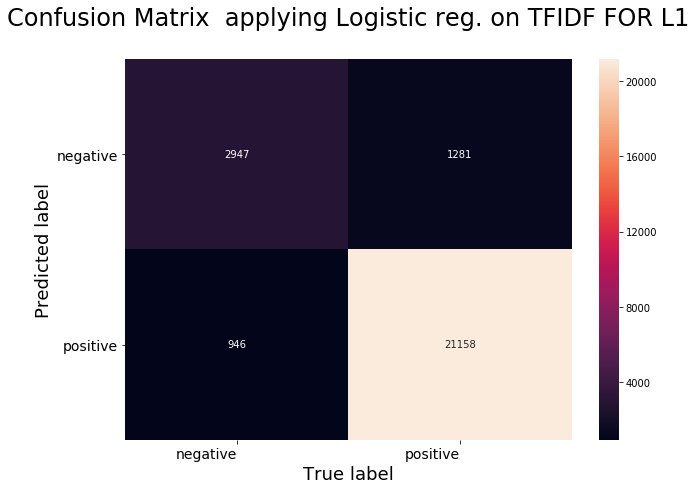

In [39]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on TFIDF FOR L1\n",size=24)
plt.show()

In [41]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



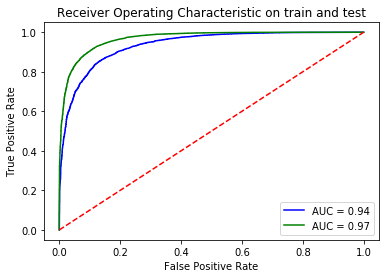

In [42]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
# SPARCITY OF our model ON C=0.1

w = lr.coef_
print(np.count_nonzero(w))

8065


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [93]:
#code for hyperparameter tuning
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l2',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.9966186033957899, 0.9999539099448973, 0.9999976072870889, 0.999997611264999, 0.999997611264999, 0.999997611264999, 0.999997611264999, 0.999997611264999, 0.999997611264999]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.9490524158765804, 0.9420283338063765, 0.9331299269530944, 0.928443082387421, 0.9251780629196085, 0.9212810112827747, 0.9196344037325886, 0.9194293386578514, 0.9194082082377683]


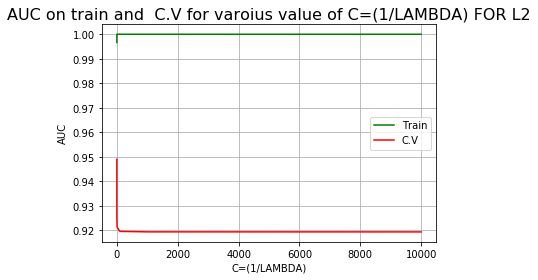

In [94]:
#code for plotting graph
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) FOR L2',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [43]:
# L.R with optimal c
lr = LogisticRegression(penalty='l2',C=.1)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha ON TFIDF= %f is %f%%' % (0.1, acc))


The accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha ON TFIDF= 0.100000 is 90.464074%


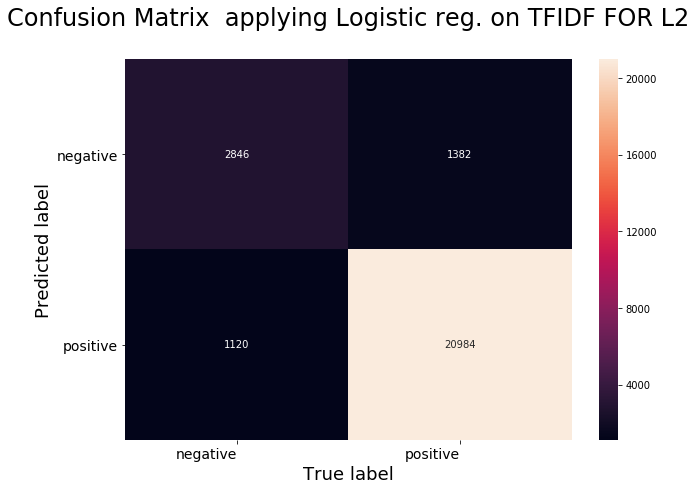

In [97]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on TFIDF FOR L2\n",size=24)
plt.show()

In [44]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



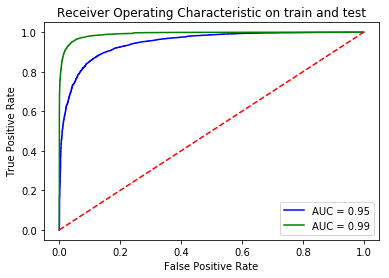

In [45]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [98]:
# SPARCITY OF our model 0.1

w = lr.coef_
print(np.count_nonzero(w))

25558


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [99]:
absolute_weights = np.absolute(w)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

  
print("Top 10 positive features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 positive features with their weight values :
       great	--> 	0.509370
        good	--> 	0.390985
        best	--> 	0.367312
        love	--> 	0.365130
   delicious	--> 	0.338409
disappointed	--> 	-0.308965
       worst	--> 	-0.277353
    not good	--> 	-0.264939
     perfect	--> 	0.264251
        nice	--> 	0.258491


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [100]:
absolute_weights = np.absolute(w)
sorted_absolute_index = np.argsort(absolute_weights)[:,::1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("Top 10 negative features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 negative features with their weight values :
   took back	--> 	0.000004
     anxious	--> 	0.000008
crackers taste	--> 	-0.000010
 like bottle	--> 	0.000011
   first try	--> 	-0.000011
certainly recommend	--> 	-0.000013
  iced green	--> 	-0.000013
 stuff could	--> 	-0.000013
 much really	--> 	0.000014
   free love	--> 	0.000015


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [46]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_tr:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
    sent_of_cv=[]
for sent in X_cv:
    sent_of_cv.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  12675


In [47]:
# compute average word2vec for each review for X_train .
Xbow_tr = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_tr.append(sent_vec)
    
# compute average word2vec for each review for X_test .
Xbow_test = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_test.append(sent_vec)
  #gdfghsdgfsdgfhsdgfdhsgfhgdhgfhdghfg


    Xbow_cv = []; 
for sent in sent_of_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    Xbow_cv.append(sent_vec)

In [48]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [111]:
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l1',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.6360978445268614, 0.8724850991168097, 0.8983952681136652, 0.9007941308737268, 0.9008314516260656, 0.9008309981443169, 0.9008307674255325, 0.9008301826727512, 0.9008331263262078]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.6310039849537497, 0.8712481873925653, 0.8990942984561402, 0.9010831231595665, 0.9010933405437631, 0.9010831014204512, 0.9010815796823795, 0.9010817101170713, 0.9011086231418274]


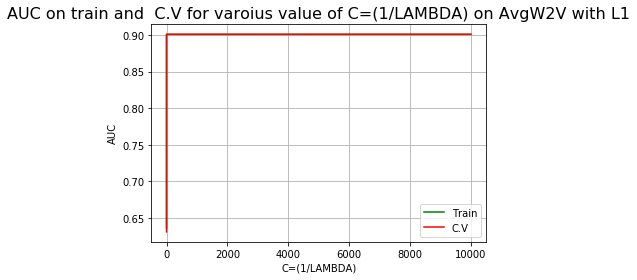

In [112]:
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) on AvgW2V with L1',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [49]:
# L.R with optimal c
lr = LogisticRegression(penalty='l1',C=.1)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha on AvgW2V = %f is %f%%' % (0.1, acc))


The accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha on AvgW2V = 0.100000 is 88.466505%


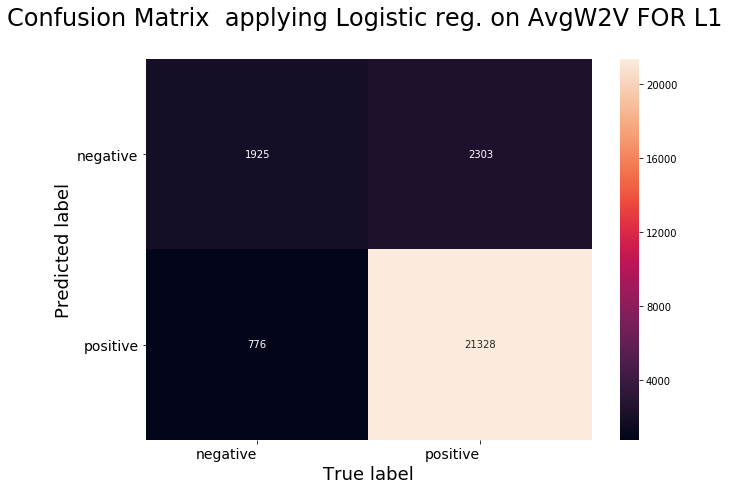

In [115]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on AvgW2V FOR L1 \n",size=24)
plt.show()

In [50]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



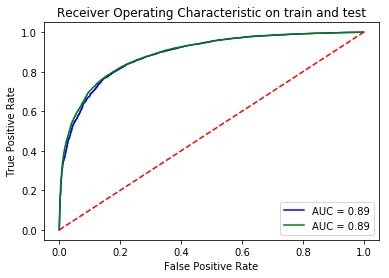

In [51]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [116]:
# SPARCITY OF our model 0.1

w = lr.coef_
print(np.count_nonzero(w))

49


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [117]:
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l2',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8871180800082383, 0.8981367397598758, 0.9005436498320226, 0.9008194502713646, 0.900828667089012, 0.900830950409396, 0.9008301428936505, 0.9008306162649495, 0.9008304571485465]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.888755653474328, 0.8995934285437018, 0.9010870362003226, 0.9010841883762167, 0.9010949709774116, 0.901098970974629, 0.9010983188011694, 0.9010983840185155, 0.9010980361926705]


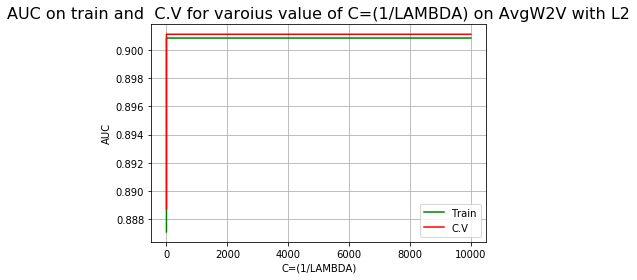

In [119]:
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) on AvgW2V with L2',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [120]:
# L.R with optimal c
lr = LogisticRegression(penalty='l2',C=.01)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha on AvgW2V = %f is %f%%' % (0.01, acc))


The accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha on AvgW2V = 0.010000 is 88.325991%


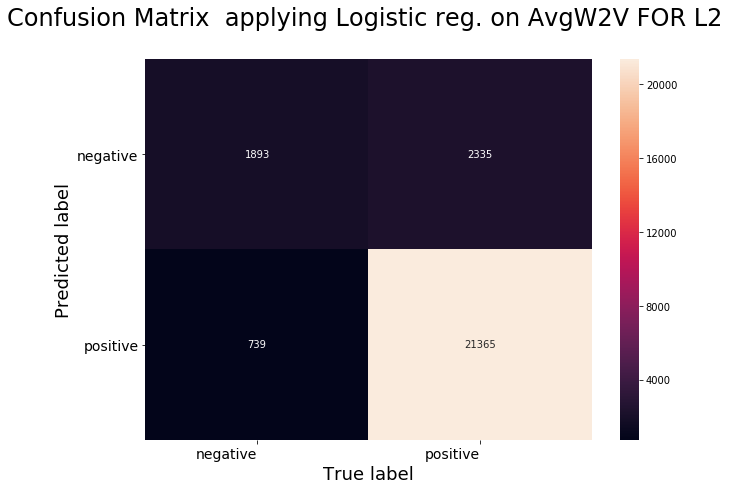

In [121]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on AvgW2V FOR L2 \n",size=24)
plt.show()

In [52]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



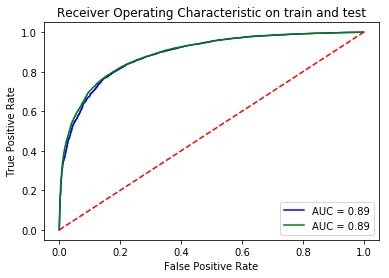

In [53]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [122]:
# SPARCITY OF our model 0.01

w = lr.coef_
print(np.count_nonzero(w))

50


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [54]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [55]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_tr.append(sent_vec)
    row += 1

In [56]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_cv)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [57]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_cv.append(sent_vec)
    row += 1

In [58]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [59]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

Xbow_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    Xbow_test.append(sent_vec)
    row += 1

In [60]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Xbow_tr_std = sc.fit_transform(Xbow_tr)
Xbow_test_std = sc.transform(Xbow_test)
Xbow_cv_std = sc.fit_transform(Xbow_cv)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [130]:
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l1',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.5782152551125026, 0.8354769866425797, 0.8713754809904886, 0.8739602434221607, 0.8740113715003754, 0.8740106992335724, 0.8740108583499756, 0.8740108623278856, 0.8740103770228562]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.5777080655074327, 0.8334385397818853, 0.8725004256518778, 0.8753093367413309, 0.8752591193849606, 0.8752432063525519, 0.8752424889617468, 0.8752441846127412, 0.8752452715685067]


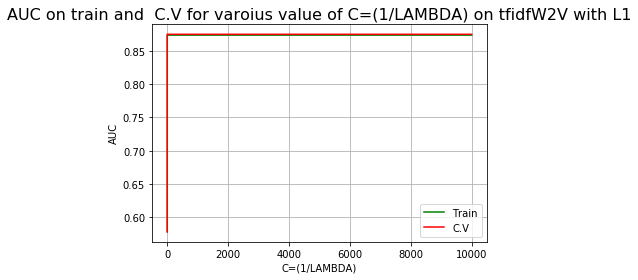

In [131]:
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) on tfidfW2V with L1',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [61]:
# L.R with optimal c
lr = LogisticRegression(penalty='l1',C=.1)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha on tfidfW2V = %f is %f%%' % (0.1, acc))


The accuracy of the LOGISTIC Regression classifier with L1 regulariser for alpha on tfidfW2V = 0.100000 is 87.357588%


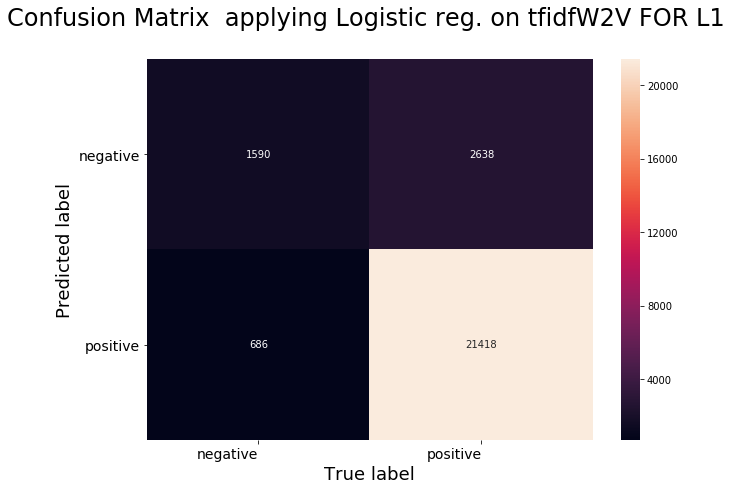

In [133]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on tfidfW2V FOR L1 \n",size=24)
plt.show()

In [62]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



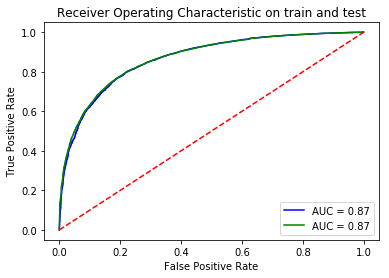

In [63]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [134]:
# SPARCITY OF our model 0.1

w = lr.coef_
print(np.count_nonzero(w))

49


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [135]:
import numpy as np
hyper = []
i = 0.0001
while(i<=10000):
    hyper.append(np.round(i,4))
    i *= 10

auc1=[]
auc2=[]

for j in hyper:
  
    model = LogisticRegression(penalty='l2',C=j)
    model.fit(Xbow_tr_std, y_tr)
    
    probs = model.predict_proba(Xbow_tr_std)
    preds = probs[:,1]
    roc_auc1=metrics.roc_auc_score(y_tr, preds)
    auc1.append(roc_auc1)
    
  
    probs = model.predict_proba(Xbow_cv_std)
    preds = probs[:,1]
    roc_auc2=metrics.roc_auc_score(y_cv, preds)
    auc2.append(roc_auc2)
    
    

    

[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
--------------------------------------------------------------------------------------------
[0.8503622664806176, 0.8698321195052338, 0.8737275317047687, 0.8740123699558047, 0.8740178674275306, 0.874018722678197, 0.8740184243349414, 0.874018304997639, 0.8740182970418188]
--------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
[0.8507346364454703, 0.8713057743090266, 0.875128684693089, 0.8752745758959471, 0.8752613585138376, 0.8752587498200002, 0.8752578150380417, 0.8752578585162722, 0.8752579454727335]


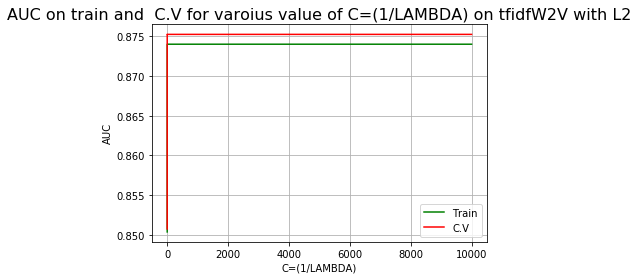

In [136]:
print(hyper)

print('--------------------------------------------------------------------------------------------')
print(auc1)

print('--------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------')
print(auc2)

plt.title('AUC on train and  C.V for varoius value of C=(1/LAMBDA) on tfidfW2V with L2',size=16)
plt.plot(hyper, auc1,'g',label ='Train')
plt.plot(hyper, auc2,'r',label ='C.V')

plt.ylabel('AUC',size=10)
plt.xlabel('C=(1/LAMBDA)',size=10)
plt.grid()
plt.legend()
plt.show()


In [64]:
# L.R with optimal c
lr = LogisticRegression(penalty='l2',C=.01)

# fitting the model
lr.fit(Xbow_tr_std, y_tr)

# predict the response
pred = lr.predict(Xbow_test_std)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha on tfidfW2V = %f is %f%%' % (0.01, acc))


The accuracy of the LOGISTIC Regression classifier with L2 regulariser for alpha on tfidfW2V = 0.010000 is 87.300623%


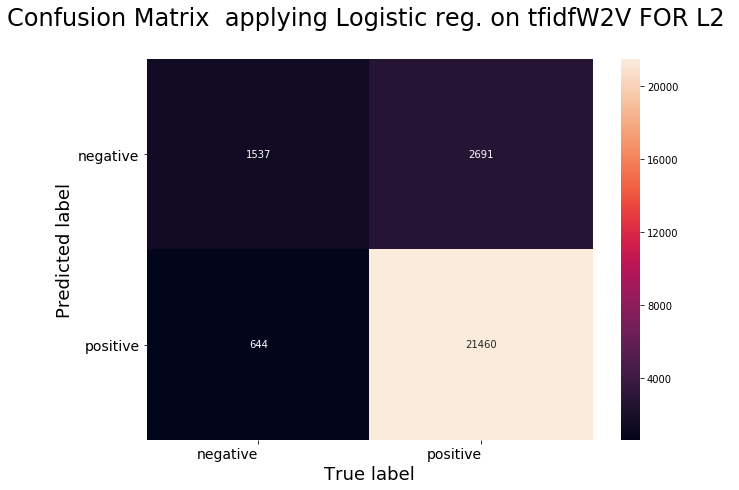

In [138]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix  applying Logistic reg. on tfidfW2V FOR L2 \n",size=24)
plt.show()

In [65]:

probs2 = lr.predict_proba(Xbow_tr)
preds2 = probs2[:,1]
fpr2, tpr2, threshold2 = metrics.roc_curve(y_tr, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)


probs1 = lr.predict_proba(Xbow_test)
preds1 = probs1[:,1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)



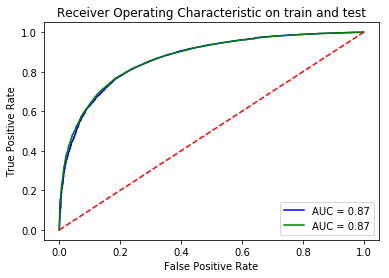

In [66]:
plt.title('Receiver Operating Characteristic on train and test')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.2f' % roc_auc2)
#plt.plot(neighbors, auc1,'g')
#plt.plot(neighbors, auc2,'r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [139]:
# SPARCITY OF our model 0.01

w = lr.coef_
print(np.count_nonzero(w))

50


# [6] Conclusions

In [157]:
# Comparing all our models using Prettytable
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vactorizer", "Regularizer(PANELTY)", "Hyperparameter(C=1/LAMBDA)", "AUC%"]

x.add_row(["BOW", "L1", .01, 90.817])
x.add_row(["BOW", "L2", .001, 91.326])
x.add_row(["TFIDF", "L1", .1, 91.641])
x.add_row(["TFIDF","L2", .1,90.498])
x.add_row(["AVGW2V", "L1",.1, 88.307])
x.add_row(["AVGW2V", "L2", .01,88.325])
x.add_row(["TFIDFW2V","L1", .1,87.376])
x.add_row(["TFIDFW2V","L2", .01, 87.334])
print(x)

+------------+----------------------+----------------------------+--------+
| Vactorizer | Regularizer(PANELTY) | Hyperparameter(C=1/LAMBDA) |  AUC%  |
+------------+----------------------+----------------------------+--------+
|    BOW     |          L1          |            0.01            | 90.817 |
|    BOW     |          L2          |           0.001            | 91.326 |
|   TFIDF    |          L1          |            0.1             | 91.641 |
|   TFIDF    |          L2          |            0.1             | 90.498 |
|   AVGW2V   |          L1          |            0.1             | 88.307 |
|   AVGW2V   |          L2          |            0.01            | 88.325 |
|  TFIDFW2V  |          L1          |            0.1             | 87.376 |
|  TFIDFW2V  |          L2          |            0.01            | 87.334 |
+------------+----------------------+----------------------------+--------+


### ------>>> WE have taken 100k points for Apply Logistic Regression on Amazon Fine Food Reviews.
 
STEP 1 :- Data cleaning (removing duplication)
    
    
STEP 2 :- Text Preprocessing


STEP 3:- Featurization on text reviews i.e BOW,TFIDF,avgW2V,TFIDF-W2V.


STEP 4:- Standardization on vectors i.e BOW,TFIDF,avgW2V,TFIDF-W2V.


STEP 5:- Applying Logistic Regression using L1 and L2 regularizer on i.e BOW,TFIDF,avgW2V,TFIDF-W2V.


STEP 6:- Using AUC as a metric and plot curve for train(predected value on itself) and C.V predected            value on train VS for each values of (C=1/lambda) in exponential scale using our own loops.


STEP 7:- Plot "AUC VS C" to analise overfitting and underfitting.


STEP 8:- Once , we analise optimal value of C then train Logistic Regrassion again with this analised          optimal C and make predictions on test_data.
 

STEP 7:- Compute test accuracy using predicted values of test_data.


STEP 8:- Plot Seaborn Heatmap for representation of Confusion Matrix on Logistic Regrassion.


STEP 9:- Plot ROC curve for train and test on each model.


STEP 10:- Compute sparsity for each model.



------>>> Repeat from STEP 4 to STEP 9 for each of these four vectorizers : Bag Of Words(BoW),TFIDF,             Avg Word2Vec and TFIDF Word2Vec saparately on L1 nad L2 Regularizer of Logistic Regression.


------>>>> Calculate sparcity on BOW L1 Regularizer for different values of (c=1/lambda) to analise              the effect of lambda on sparcity which results as W decreases as LAMBDA increases and vice            versa.


------>>>> Perform pertubation test (multicollinearity check) on BOW with L2 Regularizer which shows              there is significant difference in some weight of both vectors (i.e before adding noise              and after adding noise) so we will set a thershold and disgard them  via observing the                percentile values and for rest of weights we will use absolute value to find out important            feature extraction.


------>>>> We extract the top 10 important features from positive class and negative class from SET1              and SET2 i.e BOW AND TFIDF vectorizer  


--------------->>>>>  AT THE END WE MAKE A TABLE TO COMPAIR OUR RESULTS OF LOGISTIC REGRESSION WITH                         DIFFERENT  VECTORIZERS AND DIFFERENT REGULARIZER .